In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB
import os
sns.set(style ="whitegrid", font_scale=1.5)
from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap_colors = ["#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
color_palette = np.array(["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"])
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})
from tqdm import tqdm
import sys
import os
import pickle
import importlib
import re
from scipy.stats import norm
from scipy.linalg import sqrtm
import scipy.sparse as sp

## Data Processing

In [10]:
import importlib
import utils
importlib.reload(utils)
from utils import calc_cum_arrive, calc_cum_depart #, calc_wasted_capacity
cap = 900

In [11]:
df = pd.read_excel('BCN.xlsx').iloc[:260,:]
df['Time'] = pd.to_timedelta(df['Time'].astype(str))
df['minutes'] = df['Time'].dt.total_seconds() / 60
df['slots'] = df['minutes'] // 15
df = df[['Aircraft Capacity', 'slots']] 
latest_arrival = df['slots'].to_numpy()

In [12]:
c = np.zeros(shape=(df.shape[0], 96))
for i in range(df.shape[0]):
    for j in range(96):
        c[i,j] = abs(j - df['slots'].iloc[i] - 1)**2

In [82]:
import model
importlib.reload(model)
from model import ROSecurity

In [83]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=900, gamma=0.1, alpha=0.6, sigma=0.2, n_neighbor=1)

100%|██████████| 260/260 [00:00<00:00, 17084.74it/s]


Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.2
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.2
NonConvex  2

Optimize a model with 75496 rows, 99936 columns and 259531 nonzeros
Model fingerprint: 0x2dc342d1
Model has 96 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  QMatrix range    [1e+00, 3e+04]
  Objective range  [1e+00, 9e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 74878 rows and 74878 columns
Presolve time: 0.10s
Presolved: 24798 rows, 49238 columns, 206753 nonzeros
Presolved model has 93 second-order cone constraints
Ordering time: 0.04s

Barrier statistics:
 Dense cols : 93
 AA' NZ     : 2.631e+05
 Factor NZ  : 9.675e+05 (roughly 40 MB of memory)
 F

### Run

In [61]:
inst.base_matrix

array([[ 1. , -0.5, -0.5],
       [ 0. ,  0.5,  0.5]])

In [51]:
cap = 900
N = df.shape[0]
diag = df['Aircraft Capacity'].to_numpy()
diag = np.tile(diag, 2)
D = np.diag(diag)

m = Model('Assignment')
x = m.addVars(N, c.shape[1], vtype=GRB.CONTINUOUS, name='x')
rhs = m.addVars(c.shape[1], name="rhs_j")

chance_beta: float = 0.1
alpha = np.array([0.6] * N) 
# alpha = np.concatenate((alpha, np.array([1] * N)), axis=0)


sigma = np.zeros((2*N, 2*N))
for i in range(N):
    sigma[i, i] = 0.2


base_matrix = np.array([
[1, -1/2, -1/2],
[0,  1/2,  1/2]
])
identity_block = sp.eye(N)
A_mat = sp.kron(base_matrix, identity_block)


ppf_beta = norm.ppf(1 - chance_beta)

for j in tqdm(range(c.shape[1])):
    if j == 0:
        m.addConstr(
        (
            rhs[j] == 1/ppf_beta * (
                cap - (
                    1/2 * quicksum(alpha[i]*diag[i]*x[i,j] for i in range(N)) - 
                    1/2 * quicksum(alpha[i]*diag[i]*x[i,j+1] for i in range(N)) +
                    1/2 * quicksum(diag[i]*x[i,j+1] for i in range(N)) + 
                    1/2 * quicksum(diag[i]*x[i,j] for i in range(N))
                )
            )
        ),
        "robust_constraint_{j=0}",
    )

    elif j == c.shape[1] - 1:
        m.addConstr(
        (
            rhs[j] == 1/ppf_beta * (
                cap - (
                    1/2 * quicksum(alpha[i]*diag[i]*x[i,j] for i in range(N)) - 
                    1/2 * quicksum(alpha[i]*diag[i]*x[i,j-1] for i in range(N)) +
                    1/2 * quicksum(x[i,j]*diag[i] for i in range(N)) +
                    1/2 * quicksum(x[i,j-1]*diag[i] for i in range(N))
                )
            )
        ),
        "robust_constraint_{j=c.shape[1] - 1}",
    )
    
    else:
        m.addConstr(
            (
                rhs[j] == 1/ppf_beta * (
                    cap - (
                        quicksum(alpha[i]*diag[i]*x[i,j] for i in range(N)) - 
                        1/2 * quicksum(alpha[i]*diag[i]*x[i,j-1] for i in range(N)) - 
                        1/2 * quicksum(alpha[i]*diag[i]*x[i,j+1] for i in range(N)) +
                        1/2 * quicksum(x[i,j-1]*diag[i] for i in range(N)) +
                        1/2 * quicksum(x[i,j+1]*diag[i] for i in range(N))
                    )
                )
            ),
            "robust_constraint_{j}",
        )



        
    x_mat = m.addMVar((3*N,), name=f'x_mat_j_{j}')
    m.addConstrs((x_mat[i] == x[i, j] for i in range(N)), f"X_MVar1_j_{j}")

    if j > 0:
        m.addConstrs((x_mat[N + i] == x[i, j - 1] for i in range(N)), f"X_MVar2_j_{j}")
    else:
        m.addConstrs((x_mat[N + i] == 0 for i in range(N)), f"X_MVar2_j_{j}")


    if j < c.shape[1] - 1:
        m.addConstrs((x_mat[2*N + i] == x[i, j + 1] for i in range(N)), f"X_MVar3_j_{j}")
    else:
        m.addConstrs((x_mat[2*N + i] == 0 for i in range(N)), f"X_MVar3_j_{j}")



    m.addConstr(
        (x_mat.T @ A_mat.T @ D.T @ sigma @ D @ A_mat @ x_mat <= rhs[j] * rhs[j]),
        "cc_energy1",
    )

for i in tqdm(range(N)):
    m.addConstr(quicksum(x[i,j] for j in range(c.shape[1])) == 1)


for idx, time in enumerate(latest_arrival):
    m.addConstr(quicksum(x[idx, j] for j in range(int(time), int(c.shape[1]))) == 0)

m.setObjective(quicksum(x[i,j]*c[i,j] for i in range(N) for j in range(c.shape[1])), GRB.MINIMIZE)
m.update()
m.params.NonConvex = 2
m.params.MIPGap = 0.2
m.optimize()

100%|██████████| 260/260 [00:00<00:00, 41960.79it/s]

Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.2
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900KF, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.2
NonConvex  2

Optimize a model with 75496 rows, 149856 columns and 259531 nonzeros
Model fingerprint: 0xd0bb0dde
Model has 96 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  QMatrix range    [1e+00, 3e+04]
  Objective range  [1e+00, 9e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]


Presolve removed 74878 rows and 124798 columns
Presolve time: 0.06s
Presolved: 24798 rows, 49238 columns, 206753 nonzeros
Presolved model has 93 second-order cone constraints
Ordering time: 0.03s

Barrier statistics:
 Dense cols : 93
 AA' NZ     : 2.631e+05
 Factor NZ  : 9.675e+05 (roughly 40 MB of memory)
 Factor Ops : 7.237e+07 (less than 1 second per iteration)
 Threads    : 32

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.21617165e+08  0.00000000e+00  5.74e+04 3.96e+01  1.82e+04     0s
   1   6.68815910e+07 -2.35676882e+05  5.30e+03 9.93e-01  1.69e+03     1s
   2   1.57832439e+07 -1.69680470e+05  1.24e+03 1.49e-01  3.99e+02     1s
   3   1.44846423e+06 -1.53755589e+05  1.01e+02 2.16e-02  3.71e+01     1s
   4   2.03283684e+05 -2.46427284e+04  5.97e+00 3.03e-03  4.14e+00     1s
   5   6.65639853e+04 -3.00864017e+03  1.35e+00 8.41e-04  1.23e+00     1s
   6   3.54622308e+04  4.74656001e+02  6.64e-

In [52]:
solution = np.zeros((N, c.shape[1]))
for i in range(N):
    for j in range(c.shape[1]):
        solution[i, j] = m.getVarByName(f'x[{i},{j}]').x

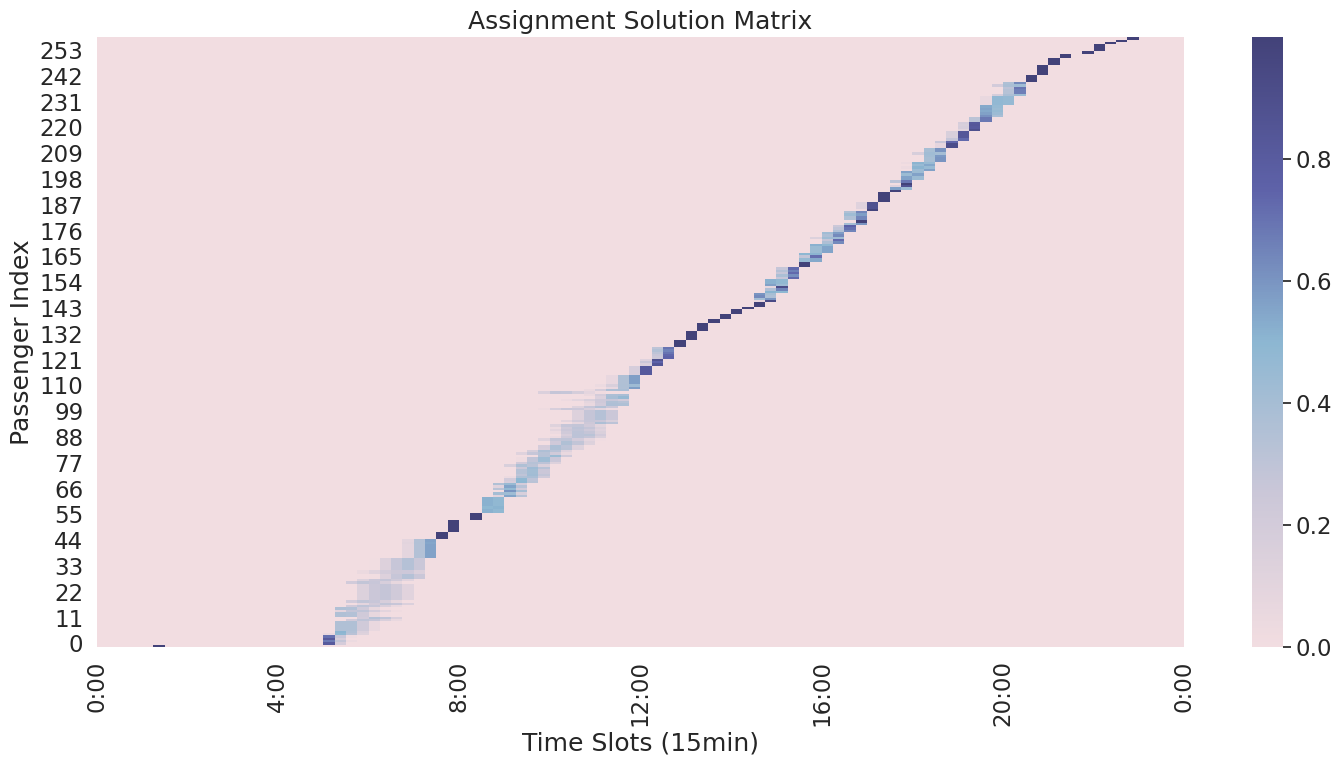

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
sns.heatmap(solution, cmap=cmap, ax=ax)
ax.set(xlabel='Time Slots (15min)', ylabel='Passenger Index',
    title='Assignment Solution Matrix')
ax.set_xticks([i*16 for i in range(6)]+[96])
ax.set_xticklabels([f"{i*4}:00" for i in range(6)]+[f"{0}:00"])
plt.tight_layout()

ax.invert_yaxis()

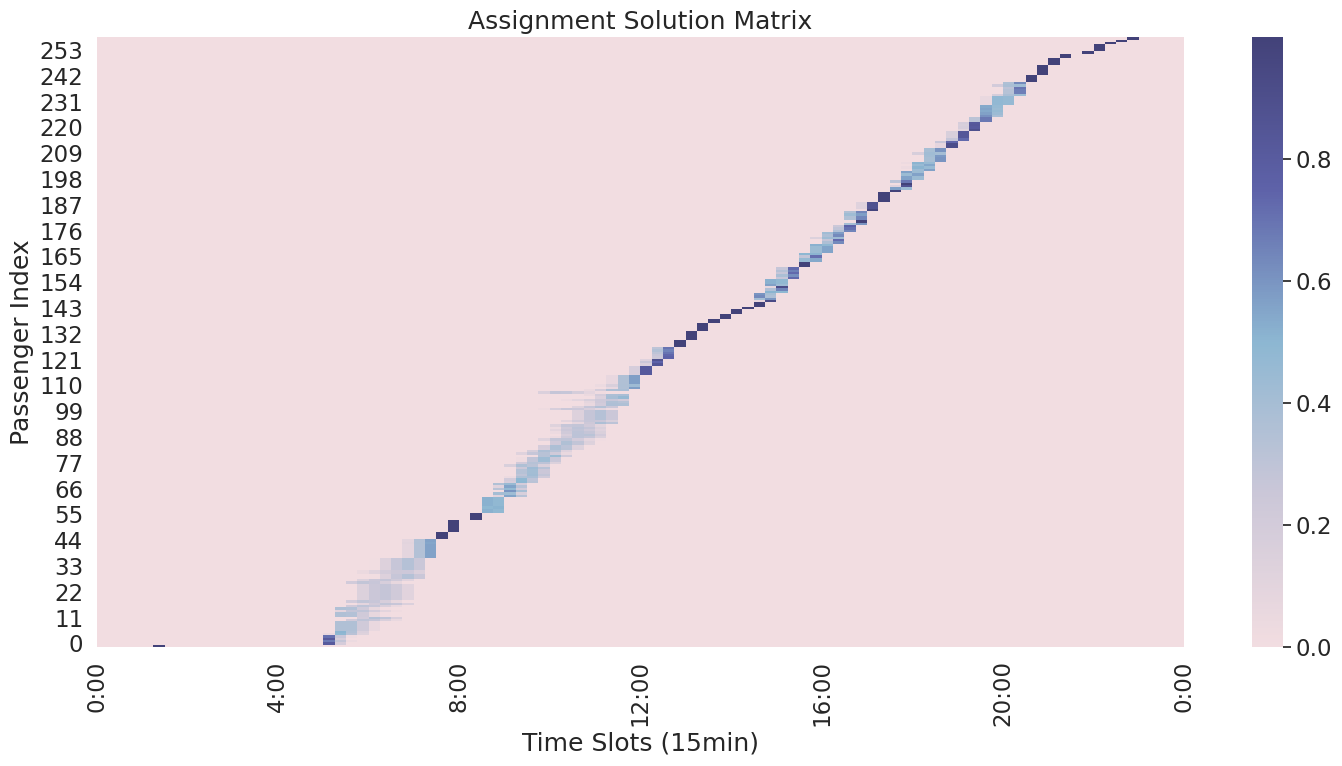

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
sns.heatmap(solution, cmap=cmap, ax=ax)
ax.set(xlabel='Time Slots (15min)', ylabel='Passenger Index',
    title='Assignment Solution Matrix')
ax.set_xticks([i*16 for i in range(6)]+[96])
ax.set_xticklabels([f"{i*4}:00" for i in range(6)]+[f"{0}:00"])
plt.tight_layout()

ax.invert_yaxis()

In [9]:
m = Model('Assignment')
x = m.addVars(c.shape[0], c.shape[1], vtype=GRB.BINARY, name='x')
for i in tqdm(range(c.shape[0])):
    m.addConstr(quicksum(x[i,j] for j in range(c.shape[1])) == 1)
for j in tqdm(range(c.shape[1])):
    m.addConstr(quicksum(x[i,j] for i in range(c.shape[0])) <= cap)
for idx, desired_arrival in enumerate(da):
    m.addConstr(quicksum(x[idx, j] for j in range(int(desired_arrival)+4, int(c.shape[1]))) == 0)

m.setObjective(quicksum(x[i,j]*c[i,j] for i in range(c.shape[0]) for j in range(c.shape[1])), GRB.MINIMIZE)
m.update()
m.setParam('OutputFlag', 0)
m.optimize()
deterministic = np.zeros((pax, c.shape[1]))
for i in range(pax):
    for j in range(c.shape[1]):
        deterministic[i, j] = m.getVarByName(f'x[{i},{j}]').x



100%|██████████| 96/96 [00:00<00:00, 3442.72it/s]


In [10]:
r1 = np.cumsum(solution.sum(axis=0))
r0 = np.cumsum(aft)

In [11]:
dm = np.cumsum(deterministic.sum(axis=0))

In [12]:
r2 = np.cumsum(solution.sum(axis=0))

In [22]:
((r2-dm)*0.25).sum()

57.0

[[<matplotlib.axis.XTick at 0x3159bdb10>,
 [Text(0, 0, '0:00'),
  Text(16, 0, '4:00'),
  Text(32, 0, '8:00'),
  Text(48, 0, '12:00'),
  Text(64, 0, '16:00'),
  Text(80, 0, '20:00'),
  Text(96, 0, '0:00')]]

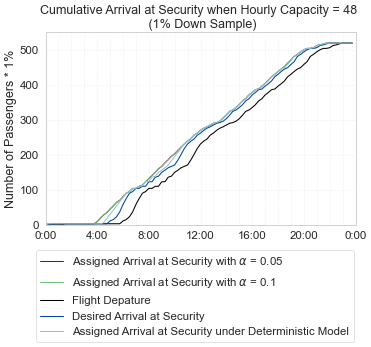

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=50)

ax.plot(r1, label=r'Assigned Arrival at Security with $\alpha$ = 0.05', color = color_platte[0])
ax.plot(r2, label=r'Assigned Arrival at Security with $\alpha$ = 0.1',color = color_platte[3])
ax.plot(aft, label='Flight Depature', color = 'black')
ax.plot(aft[4:], label='Desired Arrival at Security', color = color_platte[1])
ax.plot(dm, label='Assigned Arrival at Security under Deterministic Model',color = color_platte[2])
ax.set(title='Cumulative Arrival at Security when Hourly Capacity = 48 \n (1% Down Sample)' )
ax.legend(title='', bbox_to_anchor=(-0.05, -0.1), loc='upper left')

minorLocator = MultipleLocator(4)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(True, alpha=0.25, linestyle='--', which='both')
ax.set(xlabel='', ylabel='Number of Passengers * 1%', xlim=(0, 96), ylim=(0, 550));
ax.set(xticks=[i*16 for i in range(6)]+[96], xticklabels=[f"{i*4}:00" for i in range(6)]+[f"{0}:00"])

In [ ]:
full = pd.DataFrame({'slots':np.arange(24*4), 'capacity': cap})
full = pd.merge(full, df, on='slots', how='left')
full = full.fillna(0)
full = full.groupby('slots').agg({'capacity':'first', 'Aircraft Capacity':'sum'}).reset_index()
dt = []
vt = full['Aircraft Capacity'].cumsum()
total_departures = 0
arrival_queue = 0
for row in full.iterrows():
    arrival_queue += row[1]['Aircraft Capacity']
    departed = min(cap, arrival_queue)
    arrival_queue -= departed
    total_departures += departed
    dt.append(total_departures)
dt = np.array(dt)
expanded = []
for row in full.iterrows():
    expanded += [row[1]['slots'] for i in range(int(row[1]['Aircraft Capacity']))]

In [ ]:
def process(full, nJ=96):
    da = []
    aft = []
    nI = full['Aircraft Capacity'].sum().astype(int)
    c = np.zeros([nI, nJ])
    beta = 2
    for i in range(nI):
        lead_time = 4
        for j in range(nJ):
            desired_arrival = expanded[i] 
            actual_flight_time = expanded[i]+lead_time
            
            if j < desired_arrival:
                cost = abs(j - desired_arrival)*beta
            else:
                cost = 200
            c[i, j] = cost
        aft.append(actual_flight_time)
        da.append(desired_arrival)

    return c, np.array(aft), np.array(da)

c, aft, da = process(full)
aft = calc_cum_arrive(aft)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=200)
ax[0].plot(vt, label='$v(t)$', color=color_palette[1])
ax[0].plot(dt, label='$d(t)$', color=color_palette[3])
ax[0].plot(aft, label='$q(t)$', color=color_palette[0])
ax[0].set(xticks=np.arange(0, 24*4+1, 4*4), xticklabels=np.arange(0, 25, 4),
       xlabel='Time (hour)', ylabel='N')
ax[0].legend(loc='upper left');


ax[1].plot(reassigned_arrival, color=color_palette[1], label='$\hat{v}(t)$', linestyle='--')
ax[1].plot(reassigned_depature, color=color_palette[3], label='$\hat{d}(t)$', linestyle=':')
ax[1].plot(aft, color=color_palette[0], label='$q(t)$')

ax[1].set(xticks=np.arange(0, 24*4+1, 4*4), xticklabels=np.arange(0, 25, 4),
       xlabel='Time (hour)', ylabel='', yticklabels=[])
ax[1].legend(loc='upper left')
plt.subplots_adjust(wspace=0.05)
plt.tight_layout();